# CUHK MATH3320 Mini Project 1: Matching Pursuit


## 0. Introduction and Setup

In this project, we aim to construct a regression model using the $\ell_0$ norm constraint to perform a prediction task. We will implement the Matching Pursuit algorithm to find a sparse solution to the least squares problem.

In [27]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## 1. Finding a Dataset from the Internet

We have chosen the data Housing dataset, which is suitable for regression tasks. The dataset contains information collected from the 1990 data census, including features such as median income, housing median age, and total rooms, aiming to predict the median house value.

In [28]:
from sklearn.datasets import load_diabetes, fetch_california_housing, load_breast_cancer, load_wine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Option 1: Diabetes Dataset
data = load_diabetes()
X = data.data
y = data.target
feature_names = data.feature_names
df_diabetes = pd.DataFrame(X, columns=feature_names)
df_diabetes['Target'] = y
print('Diabetes Dataset:')
print(df_diabetes.describe())

Diabetes Dataset:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -3.639623e-16  1.309912e-16 -8.013951e-16  1.289818e-16 -9.042540e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123996e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665645e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670611e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564384e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320442e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   1.301121e-16 -4.563971e-16  3.863174e-16 -3.848103e-16 -3.398488e-16   
std    4.761905e-02  4.761905e-02

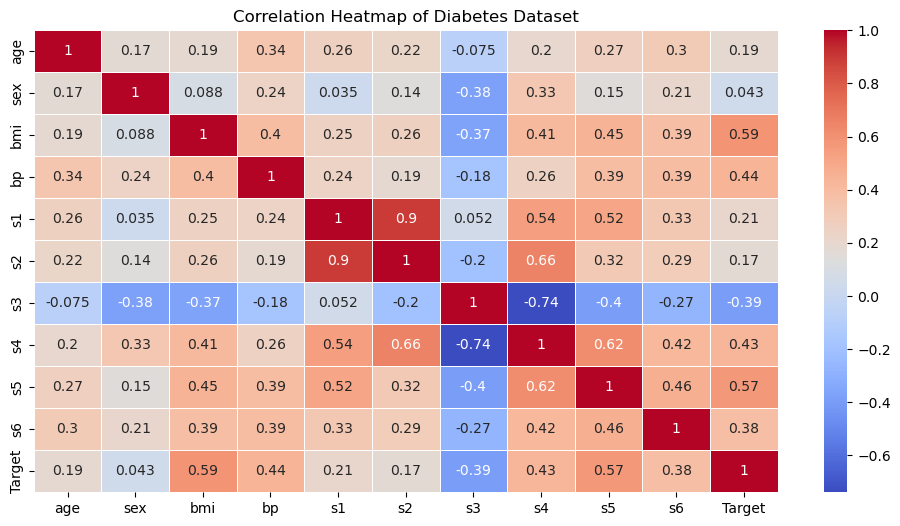

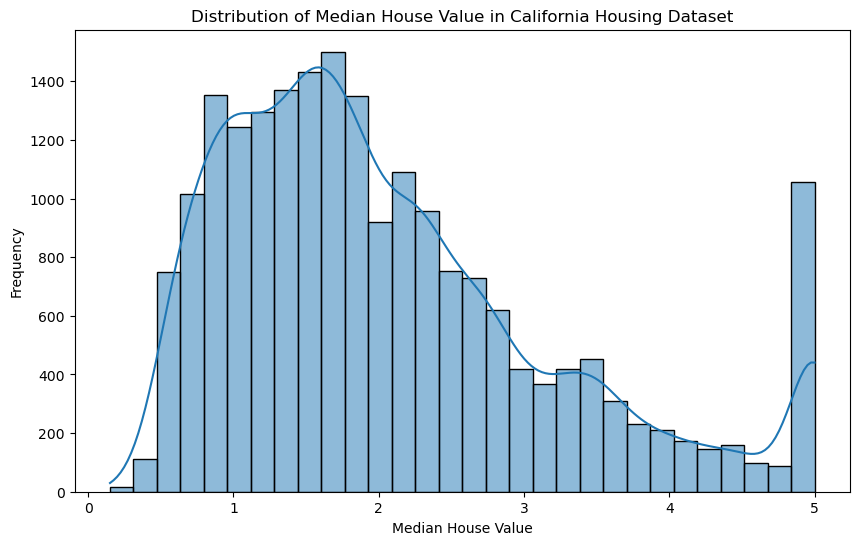

<Figure size 1200x800 with 0 Axes>

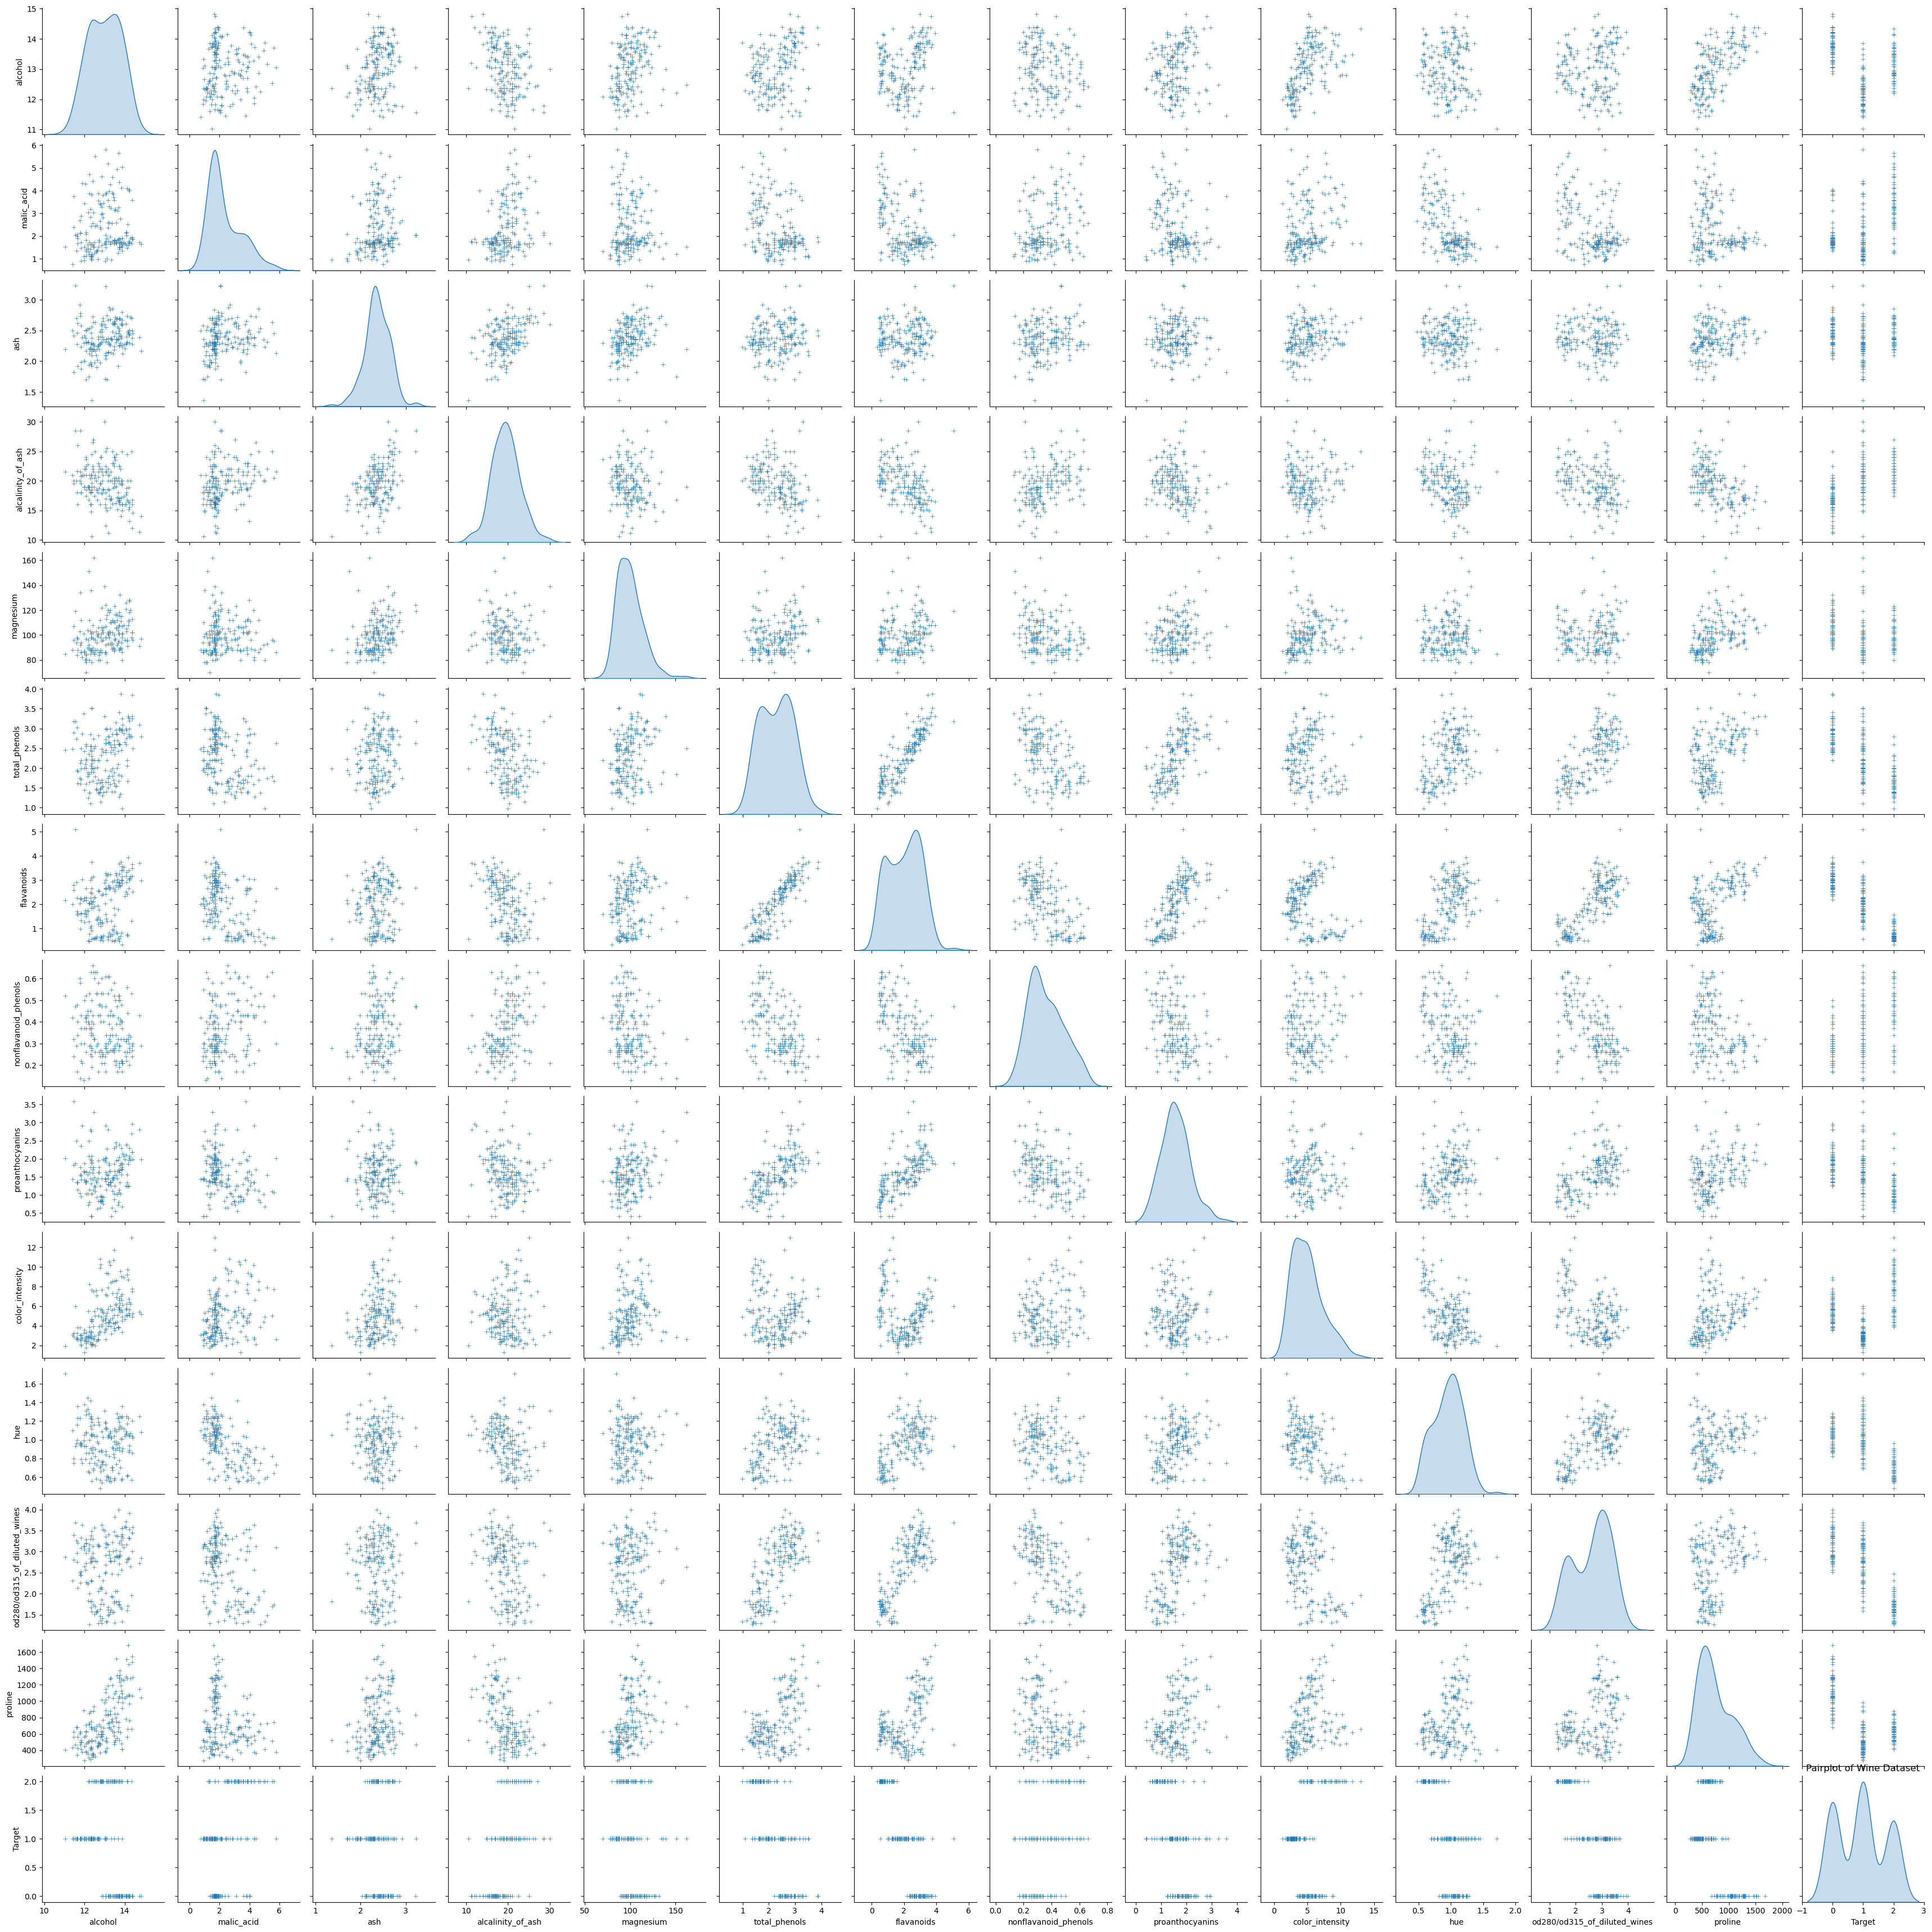

In [29]:
# Visualizing the Diabetes Dataset
plt.figure(figsize=(12, 6))
sns.heatmap(df_diabetes.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Diabetes Dataset')
plt.show()

# Visualizing target distribution for the California Housing Dataset
plt.figure(figsize=(10, 6))
sns.histplot(df_housing['MedHouseValue'], kde=True, bins=30)
plt.title('Distribution of Median House Value in California Housing Dataset')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

# Pairplot of features in the Wine Dataset
plt.figure(figsize=(12, 8))
sns.pairplot(df_wine, diag_kind='kde', markers='+')
plt.title('Pairplot of Wine Dataset')
plt.show()

## 2. Determining the Hyperparameter k by Cross-Validation

The hyperparameter k represents the maximum number of non-zero coefficients (sparsity level) in our regression model. We will use cross-validation to find the optimal kk that minimizes the prediction error.

In [30]:
# Split the data into training and validation sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100)

# Further split training data for cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=100)  # 0.25 x 0.8 = 0.2

# Standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [31]:
# Define a range of k values to test
k_values = range(1, X_train.shape[1] + 1)

# Store cross-validation errors
cv_errors = []

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=100)


## 2.5 Implementing the Matching Pursuit Algorithm

Matching Pursuit Algorithm Implementation
We will implement the Matching Pursuit algorithm as described:
1. Initialize the weights $\mathbf{w}^0=0$ and residual $\mathbf{r}^0=\mathbf{y}$.
2. While $\|\mathbf{w}\|_0<k$ :
- Find feature $i$ that maximizes $\frac{\left|\left\langle\mathbf{r}^{t-1}, \mathbf{x}_i\right\rangle\right|}{\left\|\mathbf{x}_i\right\|}$.
- Update the weight $w_i^t=w_i^{t-1}+\frac{\left\langle\mathbf{r}^{t-1}, \mathbf{x}_i\right\rangle}{\left\|\mathbf{x}_i\right\|^2}$.
- Update the residual $\mathbf{r}^t=\mathbf{r}^{t-1}-w_i^t \mathbf{x}_i$.

In [32]:
def matching_pursuit(X, y, k):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    r = y.copy()
    selected_features = []
    
    for _ in range(k):
        # Compute correlations
        correlations = X.T @ r
        norms = np.linalg.norm(X, axis=0)
        projections = np.abs(correlations) / norms
        
        # Avoid selecting the same feature
        for idx in selected_features:
            projections[idx] = 0
        
        # Select the feature with maximum projection
        i = np.argmax(projections)
        selected_features.append(i)
        
        # Update weight for feature i
        w_i = (X[:, i] @ r) / (X[:, i] @ X[:, i])
        w[i] += w_i
        
        # Update residual
        r = r - w_i * X[:, i]
        
        # Print intermediate results
        print(f"Iteration {_+1}: Selected feature {i}, Weight update {w_i}, Residual norm {np.linalg.norm(r)}")
    
    return w


In [33]:
# Initialize cv_errors
cv_errors = []

for k in k_values:
    errors = []
    for train_index, val_index in kf.split(X_train_scaled):
        X_kf_train, X_kf_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_kf_train, y_kf_val = y_train[train_index], y_train[val_index]
        
        # Train Matching Pursuit with current k
        w = matching_pursuit(X_kf_train, y_kf_train, k)
        
        # Predict on validation set
        y_pred = X_kf_val @ w
        
        # Compute Mean Squared Error
        mse = mean_squared_error(y_kf_val, y_pred)
        errors.append(mse)
    
    # Average error for current k
    mean_error = np.mean(errors)
    cv_errors.append(mean_error)
    print(f"k = {k}, Cross-Validation MSE = {mean_error}")


Iteration 1: Selected feature 2, Weight update 48.240827957115506, Residual norm 2382.648149162257
Iteration 1: Selected feature 2, Weight update 50.43866235639003, Residual norm 2388.2823459927454
Iteration 1: Selected feature 2, Weight update 36.787632944542466, Residual norm 2376.820951443887
Iteration 1: Selected feature 2, Weight update 44.47659093466946, Residual norm 2348.471003639605
Iteration 1: Selected feature 8, Weight update 43.28417007695992, Residual norm 2416.392103710858
k = 1, Cross-Validation MSE = 27424.02579076164
Iteration 1: Selected feature 2, Weight update 48.240827957115506, Residual norm 2382.648149162257
Iteration 2: Selected feature 8, Weight update 27.221292781561722, Residual norm 2348.996516062578
Iteration 1: Selected feature 2, Weight update 50.43866235639003, Residual norm 2388.2823459927454
Iteration 2: Selected feature 8, Weight update 19.616304895260193, Residual norm 2371.7359925330034
Iteration 1: Selected feature 2, Weight update 36.787632944542

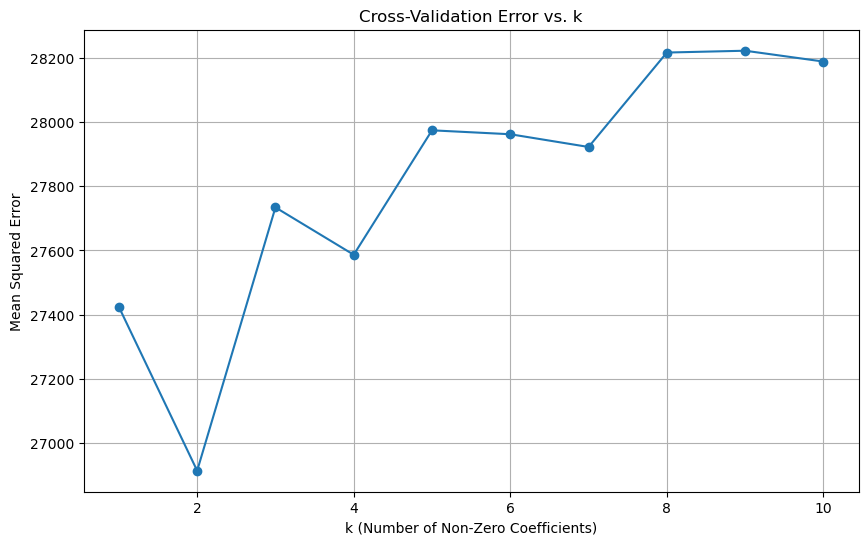

In [34]:
# Plotting Cross-Validation Error vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_errors, marker='o')
plt.title('Cross-Validation Error vs. k')
plt.xlabel('k (Number of Non-Zero Coefficients)')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

Analysis:

The cross-validation process evaluates the performance of the Matching Pursuit algorithm for different values of $k$. 

By plotting the Mean Squared Error against $k$, we can identify the value of $k$ that minimizes the error.

## 3. Programming the Matching Pursuit Algorithm

The Matching Pursuit algorithm has been implemented in the previous section. Here, we will demonstrate how it works on our training data with the optimal kk determined from cross-validation.

In [35]:
# Determine the optimal k
optimal_k = k_values[np.argmin(cv_errors)]
print(f"The optimal value of k is {optimal_k}")

The optimal value of k is 2


In [36]:
# Train Matching Pursuit on the full training data with optimal k
w_optimal = matching_pursuit(X_train_scaled, y_train, optimal_k)

# Non-zero coefficients
non_zero_indices = np.nonzero(w_optimal)[0]
print(f"Selected features: {non_zero_indices}")
print(f"Weights of selected features: {w_optimal[non_zero_indices]}")

Iteration 1: Selected feature 2, Weight update 44.50749971283922, Residual norm 2665.0614949562173
Iteration 2: Selected feature 8, Weight update 21.78720578518983, Residual norm 2641.445936454833
Selected features: [2 8]
Weights of selected features: [44.50749971 21.78720579]


## 4. Detailed Report and Analysis
Feature Selection and Interpretation

In [37]:
# Mapping feature indices to names
selected_feature_names = [feature_names[i] for i in non_zero_indices]
print(f"Selected feature names: {selected_feature_names}")

Selected feature names: ['bmi', 's5']


Analysis:?

In [38]:
# Compute residuals on training set
y_train_pred = X_train_scaled @ w_optimal
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Training Mean Squared Error: {train_mse}")

Training Mean Squared Error: 26428.926648536923


Analysis:?

## 5. Final Prediction Error on Test Dataset

Now, we will evaluate the model's performance on the test dataset using the optimal k.

In [39]:
# Predict on test data
y_test_pred = X_test_scaled @ w_optimal

# Compute Mean Squared Error on test data
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test Mean Squared Error: {test_mse}")

Test Mean Squared Error: 26549.488874813218


Result

    Optimal Hyperparameter k: The optimal value of kk determined by cross-validation is ...
    
    Final Prediction Error: The test Mean Squared Error is ...